Loaded 800 'Real' fingerprint images.
Loaded 2400 'Altered' fingerprint images.
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
PKBT applied to features.
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5650 - loss: 5.5433 - val_accuracy: 0.9198 - val_loss: 4.4592
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8159 - loss: 4.3684 - val_accuracy: 1.0000 - val_loss: 3.5905
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9335 - loss: 3.5494 - val_accuracy: 1.0000 - val_loss: 2.9711
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9732 - loss: 2.9069 - val_accuracy: 1.0000 - val_loss: 2.4436
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 2.3634 - val_accuracy: 1.0000 - val_loss: 1.9860
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 1.9149 - val_accuracy: 1.0000 - val_loss: 1.5954
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9912 - loss: 1.5366 - val_accur

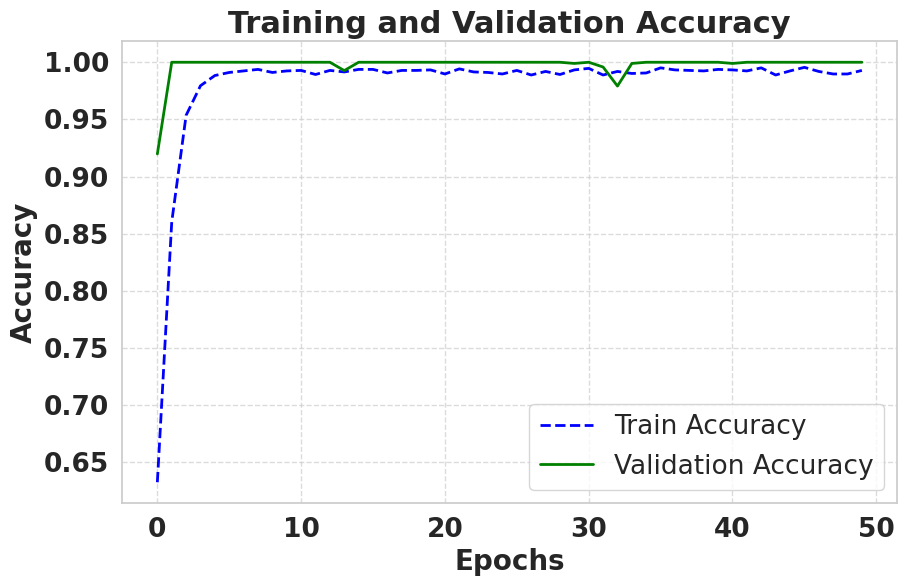

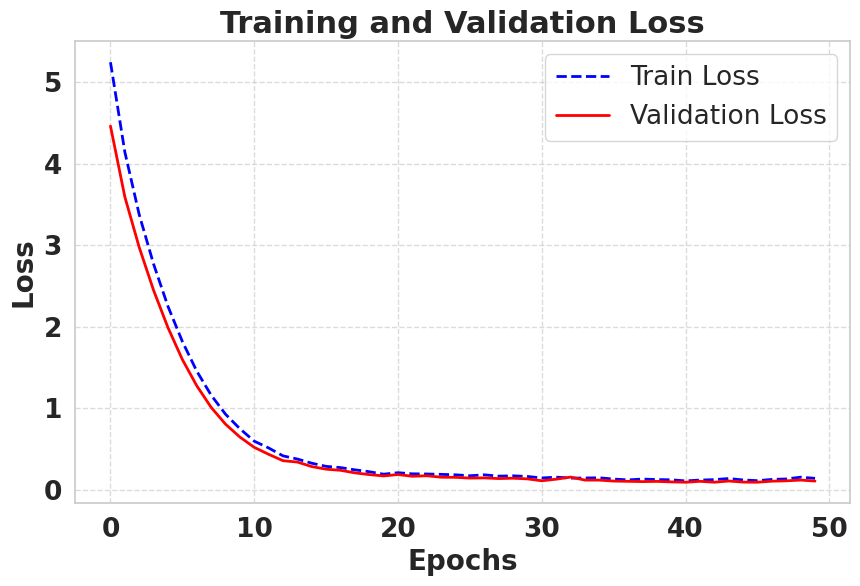

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


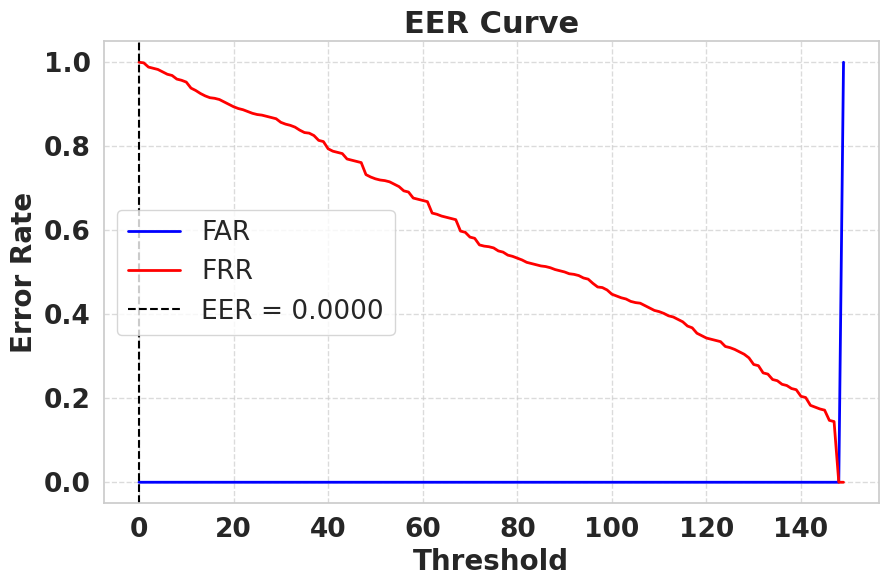

EER for Residual Dense Model with PKBT: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


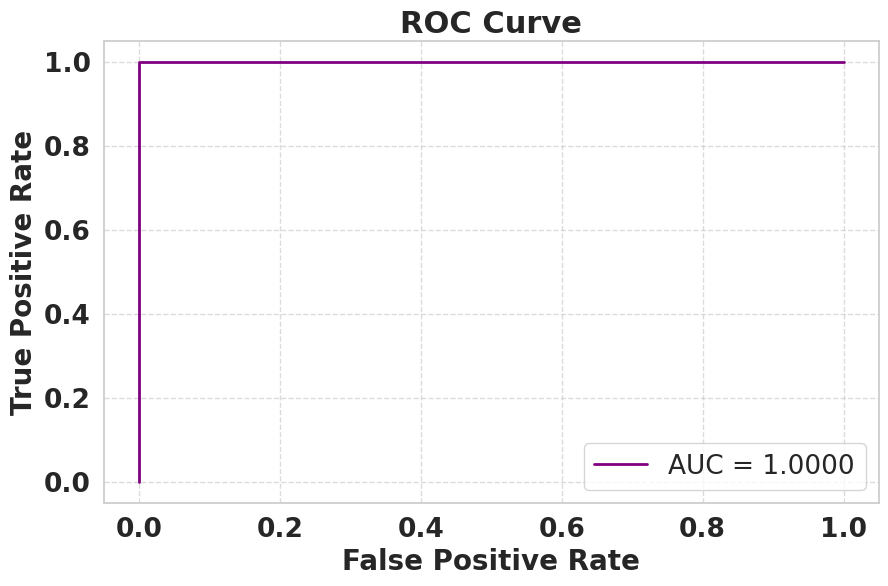

In [16]:
#1-classification task 
import os
import cv2
import numpy as np
from scipy.signal import hilbert
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
SEED = 3401567888
KEY = np.random.randint(1, 255, (128,), dtype=np.uint8)  # Secret key for transformation
output_dir = "./"  # Directory to save graphs

# Load and preprocess fingerprint images
def load_and_preprocess_images(paths_real, paths_altered):
    images, labels = [], []
    real_count, altered_count = 0, 0

    for root_dir_real in paths_real:
        for subdir, dirs, files in os.walk(root_dir_real):
            for filename in files:
                if filename.upper().endswith(".TIF"):
                    img_path = os.path.join(subdir, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_resized = cv2.resize(img, IMAGE_SIZE)
                        images.append(img_resized)
                        labels.append(0)
                        real_count += 1

    print(f"Loaded {real_count} 'Real' fingerprint images.")

    for root_dir_altered in paths_altered:
        for subdir, dirs, files in os.walk(root_dir_altered):
            for filename in files:
                if filename.upper().endswith(".TIF"):
                    img_path = os.path.join(subdir, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_resized = cv2.resize(img, IMAGE_SIZE)
                        images.append(img_resized)
                        labels.append(1)
                        altered_count += 1

    print(f"Loaded {altered_count} 'Altered' fingerprint images.")
    return np.array(images), np.array(labels)

# MobileNet Feature Extraction
def build_mobilenet_feature_extractor(fine_tune=True):
    mobilenet_base = MobileNet(weights=weights, include_top=False, input_shape=IMAGE_SIZE + (3,))
    if fine_tune:
        for layer in mobilenet_base.layers[-20:]:
            layer.trainable = True
    else:
        for layer in mobilenet_base.layers:
            layer.trainable = False

    model = Sequential([mobilenet_base, GlobalAveragePooling2D(), Flatten()])
    return model

def extract_features_mobilenet(images):
    mobilenet_model = build_mobilenet_feature_extractor(fine_tune=True)
    images = mobilenet_preprocess_input(np.array(images, dtype=np.float32))
    features = mobilenet_model.predict(images)
    return features

# Phase-Keyed Biometric Transformation (PKBT)
def apply_pkbt(features, key):
    analytic_signal = hilbert(features, axis=1)  # Compute Hilbert transform along the feature dimension
    magnitude = np.abs(analytic_signal)  # Compute the magnitude
    phase = np.angle(analytic_signal)  # Compute the phase

    # Modulate the phase with the key
    expanded_key = np.tile(key, (features.shape[0], 1))
    modulated_phase = (phase + expanded_key / 255.0) % (2 * np.pi)

    # Reconstruct the signal with modulated phase
    transformed_features = magnitude * np.exp(1j * modulated_phase)
    transformed_features = np.real(transformed_features)  # Take the real part

    print("PKBT applied to features.")
    return transformed_features

# Updated Feature Extraction Pipeline
def process_features_with_pkbt(images):
    mobilenet_features = extract_features_mobilenet(images)
    key = np.random.randint(1, 255, (mobilenet_features.shape[1],), dtype=np.uint8)
    pkbt_transformed_features = apply_pkbt(mobilenet_features, key)
    return pkbt_transformed_features

# Residual Dense Model
def build_residual_dense(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Updated Plotting Functions
sns.set(style="whitegrid", palette="muted")

def plot_accuracy(history, model_name="Neural Network"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='-', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=22, fontweight='bold')
    plt.xlabel('Epochs', fontsize=20, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=20, fontweight='bold')
    plt.legend(loc='lower right', fontsize=19)
    plt.xticks(fontsize=19, fontweight='bold')
    plt.yticks(fontsize=19, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}{model_name}_accuracy.png")
    plt.show()

def plot_loss(history, model_name="Neural Network"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=22, fontweight='bold')
    plt.xlabel('Epochs', fontsize=20, fontweight='bold')
    plt.ylabel('Loss', fontsize=20, fontweight='bold')
    plt.legend(loc='upper right', fontsize=19)
    plt.xticks(fontsize=19, fontweight='bold')
    plt.yticks(fontsize=19, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}{model_name}_loss.png")
    plt.show()

def plot_eer(y_true, y_score, model_name="Neural Network"):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, label='FAR', color='blue', linewidth=2)
    plt.plot(fnr, label='FRR', color='red', linewidth=2)
    plt.axvline(x=eer, linestyle='--', color='black', label=f'EER = {eer:.4f}')
    plt.title('EER Curve', fontsize=22, fontweight='bold')
    plt.xlabel('Threshold', fontsize=20, fontweight='bold')
    plt.ylabel('Error Rate', fontsize=20, fontweight='bold')
    plt.legend(fontsize=19)
    plt.xticks(fontsize=19, fontweight='bold')
    plt.yticks(fontsize=19, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}{model_name}_eer.png")
    plt.show()
    print(f"EER for {model_name}: {eer:.4f}")

def plot_roc_curve(y_true, y_score, model_name="Neural Network"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', linewidth=2, color='purple')
    plt.title('ROC Curve', fontsize=22, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=20, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=20, fontweight='bold')
    plt.legend(loc='lower right', fontsize=19)
    plt.xticks(fontsize=19, fontweight='bold')
    plt.yticks(fontsize=19, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}roc_curve.png")
    plt.show()

# Load Images
paths_real = ["/kaggle/input/fycalldaatsetsss/74034_3_En_4_MOESM1_ESM/FVC2002/Dbs/Db1_a"]
paths_altered = [
   
    "/kaggle/working/2002/DB211/blur",
    "/kaggle/working/2002/DB211/distortion",
    "/kaggle/working/2002/DB211/noise"
    
]

images, labels = load_and_preprocess_images(paths_real, paths_altered)
weights = "/kaggle/input/mobilenet/mobilenet_1_0_224_tf_no_top (3).h5"

# Feature Processing
transformed_features = process_features_with_pkbt(images)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(transformed_features, labels, test_size=0.3, shuffle=True, random_state=42)

# Train Model
input_shape = (X_train.shape[1],)
model = build_residual_dense(input_shape, num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plotting Results
plot_accuracy(history, model_name="Residual Dense Model with PKBT")
plot_loss(history, model_name="Residual Dense Model with PKBT")
plot_eer(y_test, model.predict(X_test).ravel(), model_name="Residual Dense Model with PKBT")
plot_roc_curve(y_test, model.predict(X_test).ravel(), model_name="Residual Dense Model with PKBT")
